# Understand and optimize ESN hyperparameters

This chapter gives very basic clues on how to interpret the action of some first importance hyperparameters of an Echo stat networks.

It also present a very basic example of optimization using [hyperopt](http://hyperopt.github.io/hyperopt/) and [reservoirpy.hyper](https://reservoirpy.readthedocs.io/en/latest/api/reservoirpy.hyper.html) tools.

## Understand ESN hyperparameters

In [1]:
UNITS = 100               # - number of neurons
LEAK_RATE = 0.3           # - leaking rate
SPECTRAL_RADIUS = 1.25    # - spectral radius of W
INPUT_SCALING = 1.0       # - input scaling
RC_CONNECTIVITY = 0.1     # - density of reservoir internal matrix
INPUT_CONNECTIVITY = 0.2  # and of reservoir input matrix
REGULARIZATION = 1e-8     # - regularization coefficient for ridge regression
SEED = 1234               # for reproductibility

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from reservoirpy.nodes import Reservoir, Ridge
from reservoirpy.datasets import mackey_glass

import reservoirpy as rpy
rpy.verbosity(0)

X = mackey_glass(2000)

# rescale between -1 and 1
X = 2 * (X - X.min()) / (X.max() - X.min()) - 1

We will use Mackey-Glass timeseries as inputs for this example. Mackey-Glass timeseries is a chaotic univariate timeseries.

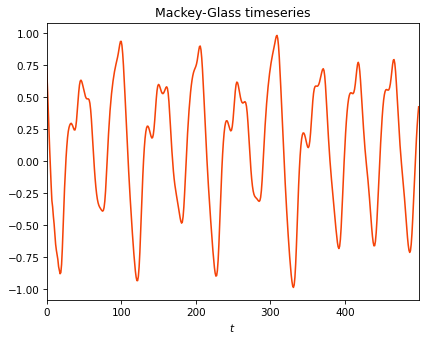

In [3]:
plt.figure()
plt.xlabel("$t$")
plt.title("Mackey-Glass timeseries")
plt.plot(X[:500])
plt.show()

### Spectral radius

The *spectral radius* is the **maximum absolute eigenvalue of the reservoir matrix $W$**.

In [4]:
states = []
spectral_radii = [0.1, 1.25, 10.0]
for spectral_radius in spectral_radii:
    reservoir = Reservoir(
        units=UNITS, 
        sr=spectral_radius, 
        input_scaling=INPUT_SCALING, 
        lr=LEAK_RATE, 
        rc_connectivity=RC_CONNECTIVITY,
        input_connectivity=INPUT_CONNECTIVITY,
        seed=SEED,
    )

    s = reservoir.run(X[:500])
    states.append(s)

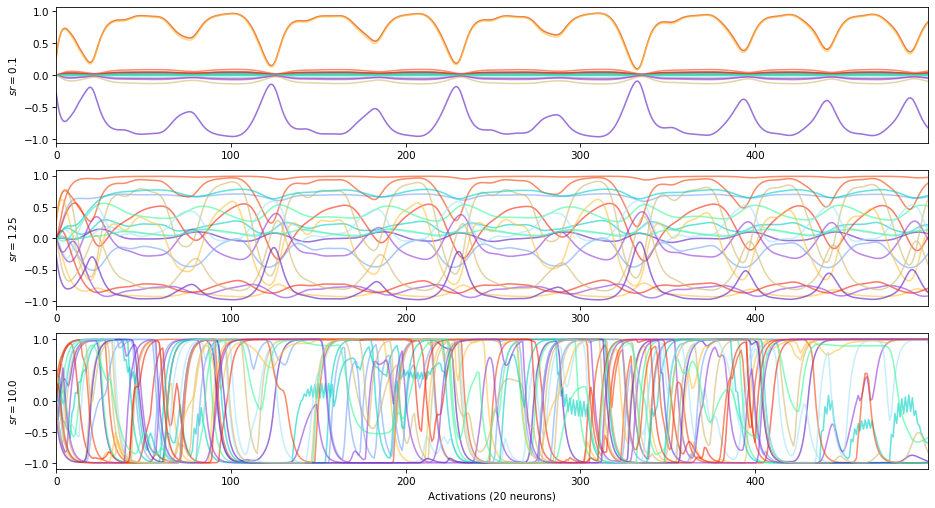

In [5]:
UNITS_SHOWN = 20

plt.figure(figsize=(15, 8))
for i, s in enumerate(states):
    plt.subplot(len(spectral_radii), 1, i+1)
    plt.plot(s[:, :UNITS_SHOWN], alpha=0.6)
    plt.ylabel(f"$sr={spectral_radii[i]}$")
plt.xlabel(f"Activations ({UNITS_SHOWN} neurons)")
plt.show()

- $-$ spectral radius $\rightarrow$ **stable** dynamics

- $+$ spectral radius $\rightarrow$ **chaotic** dynamics

Spectral radius and *Echo State Property*: a spectral radius close to 1 is supposed, **under certain theoretical assumptions only**, to allow the reservoir states to be less affected by their initial conditions, while having good memorization properties. **In practice, a random search algorithm is the most robust way to find the optimal spectral radius for a precise task.**

### Input scaling

The input scaling is a **coefficient applied on $W_{in}$** and adding a gain to the inputs of the reservoir.

In [6]:
states = []
input_scalings = [0.1, 1.0, 10.]
for input_scaling in input_scalings:
    reservoir = Reservoir(
        units=UNITS, 
        sr=SPECTRAL_RADIUS, 
        input_scaling=input_scaling, 
        lr=LEAK_RATE,
        rc_connectivity=RC_CONNECTIVITY, 
        input_connectivity=INPUT_CONNECTIVITY, 
        seed=SEED,
    )

    s = reservoir.run(X[:500])
    states.append(s)

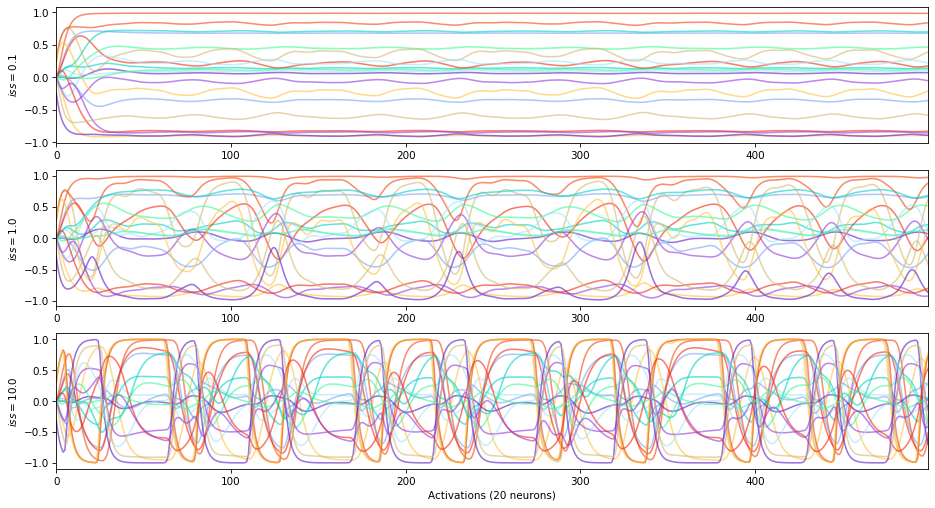

In [7]:
UNITS_SHOWN = 20

plt.figure(figsize=(15, 8))
for i, s in enumerate(states):
    plt.subplot(len(input_scalings), 1, i+1)
    plt.plot(s[:, :UNITS_SHOWN], alpha=0.6)
    plt.ylabel(f"$iss={input_scalings[i]}$")
plt.xlabel(f"Activations ({UNITS_SHOWN} neurons)")
plt.show()

Average correlation between reservoir states and inputs:

In [8]:
def correlation(states, inputs):
    correlations = [np.corrcoef(states[:, i].flatten(), inputs.flatten())[0, 1] for i in range(states.shape[1])]
    return np.mean(np.abs(correlations))

In [9]:
print("input_scaling    correlation")
for i, s in enumerate(states):
    corr = correlation(states[i], X[:500])
    print(f"{input_scalings[i]: <13}    {corr}")

input_scaling    correlation
0.1              0.16324249555087234
1.0              0.456074569566359
10.0             0.5844237964783198


- $+$ input scaling $\rightarrow$ **high states *vs* inputs correlation** (until saturation)
- $-$ input scaling $\rightarrow$ **free running states**

The *input scaling* can also be used to adjust the influence of each variable in a multivariates timeseries.

### Leaking rate


$$
x(t+1) =  {\color{red}(1 - \alpha)} \underbrace{x(t)}_{\text{current}} + {\color{red}\alpha} \underbrace{f(u(t+1), x(t))}_{\text{new inputs}}
$$

with $\alpha \in [0, 1]$ and:

$$ f(u, x) = \tanh(W_{in} \cdotp u + W \cdotp x) $$

In [10]:
states = []
leaking_rates = [0.02, 0.3, 1.0]
for leaking_rate in leaking_rates:
    reservoir = Reservoir(
        units=UNITS, 
        sr=SPECTRAL_RADIUS, 
        input_scaling=INPUT_SCALING, 
        lr=leaking_rate,
        rc_connectivity=RC_CONNECTIVITY, 
        input_connectivity=INPUT_CONNECTIVITY, 
        seed=SEED
    )

    s = reservoir.run(X[:500])
    states.append(s)

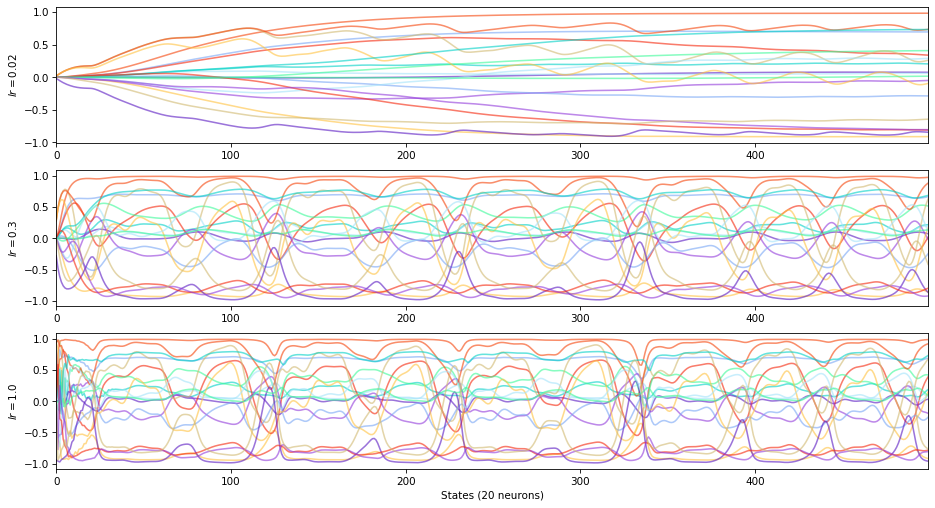

In [11]:
UNITS_SHOWN = 20

plt.figure(figsize=(15, 8))
for i, s in enumerate(states):
    plt.subplot(len(leaking_rates), 1, i+1)
    plt.plot(s[:, :UNITS_SHOWN], alpha=0.6)
    plt.ylabel(f"$lr={leaking_rates[i]}$")
plt.xlabel(f"States ({UNITS_SHOWN} neurons)")
plt.show()

- $+$ leaking rate $\rightarrow$ **low inertia**, low recall of previous states
- $-$ leaking rate $\rightarrow$ **high inertia**, high recall of previous states

The *leaking rate* controls the time constant of the ESN.

## Optimize hyperparameters

**Before getting started**, users should learn more about [hyperopt](http://hyperopt.github.io/hyperopt/) optimization tools. ReservoirPy only provide users with some wrappers around those tools.

In the following example, we will try to find the best parameters to forecast a double-scroll attractor 10 steps ahead.

In [12]:
from reservoirpy.datasets import doublescroll

timesteps = 2000
x0 = [0.37926545, 0.058339, -0.08167691]
X = doublescroll(timesteps, x0=x0, method="RK23")

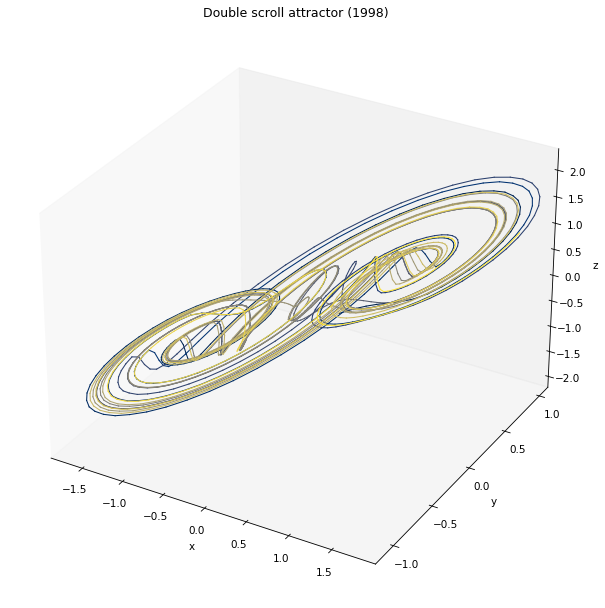

In [13]:
fig = plt.figure(figsize=(10, 10))
ax  = fig.add_subplot(111, projection='3d')
ax.set_title("Double scroll attractor (1998)")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.grid(False)

for i in range(timesteps-1):
    ax.plot(X[i:i+2, 0], X[i:i+2, 1], X[i:i+2, 2], color=plt.cm.cividis(255*i//timesteps), lw=1.0)

plt.show()

### Step 1: define the objective

The first steps consists in defining the objective function you want to optimize. This is the most important step: you must define an experimentation which is reproducible and which will produce results that can be measured to approximate the function you want to optimize.

Most optimization algorithms relies on the hypothesis of convexity (like most estimators in machine learning). In our case, that means that hyperopt expects that the objective function have at least some local minima that can be reached by shifting the parameters.

We therefore chose RMSE (Root Mean Squared Error) as a loss function, the function that will be used within the objective function to evaluate the quality of the parameters we chose. We can make the assumption that this function, combined with the model function of the ESN, has a least some local minima without taking to much risks. Of course, we do not know the shape of this function, and we can't "plot it" to see where the minimum is. This is why we will rely on tools like hyperopt to approximate this function in many points, and empirically find a minimum.

In addition to the loss function, we also compute an other metric, the $R^2$.

In [14]:
from reservoirpy.observables import nrmse, rsquare

In [15]:
# Objective functions accepted by ReservoirPy must respect some conventions:
#  - dataset and config arguments are mandatory, like the empty '*' expression.
#  - all parameters that will be used during the search must be placed after the *.
#  - the function must return a dict with at least a 'loss' key containing the result
# of the loss function. You can add any additional metrics or information with other 
# keys in the dict. See hyperopt documentation for more informations.
def objective(dataset, config, *, input_scaling, N, sr, lr, ridge, seed):
    # This step may vary depending on what you put inside 'dataset'
    x_train, y_train, x_test, y_test = dataset
    
    # You can access anything you put in the config 
    # file from the 'config' parameter.
    instances = config["instances_per_trial"]
    
    # The seed should be changed across the instances, 
    # to be sure there is no bias in the results 
    # due to initialization.
    variable_seed = seed 
    
    losses = []; r2s = [];
    for n in range(instances):
        # Build your model given the input parameters
        reservoir = Reservoir(
            units=N, 
            sr=sr, 
            lr=lr, 
            input_scaling=input_scaling, 
            seed=variable_seed
        )

        readout = Ridge(ridge=ridge)

        model = reservoir >> readout


        # Train your model and test your model.
        predictions = model.fit(x_train, y_train) \
                           .run(x_test)
        
        loss = nrmse(y_test, predictions, norm_value=np.ptp(x_train))
        r2 = rsquare(y_test, predictions)
        
        # Change the seed between instances
        variable_seed += 1
        
        losses.append(loss)
        r2s.append(r2)

    # Return a dictionnary of metrics. The 'loss' key is mandatory when
    # using hyperopt.
    return {'loss': np.mean(losses),
            'r2': np.mean(r2s)}

### Step 2: define the research space

We can now define how we want hyperopt to find a minimum of the loss function, and what parameters we want to optimize.

Hyperopt configuration files can be written as shown in the next cell. The "exp", "hp_max_evals", "hp_method" and "hp_space" are mandatory. All the other keys are optional, like "seed", or are user-defined.

In [16]:
import json

hyperopt_config = {
    "exp": "hyperopt-multiscroll",    # the experimentation name
    "hp_max_evals": 200,              # the number of differents sets of parameters hyperopt has to try
    "hp_method": "random",            # the method used by hyperopt to chose those sets (see below)
    "seed": 42,                       # the random state seed, to ensure reproducibility
    "instances_per_trial": 3,         # how many random ESN will be tried with each sets of parameters
    "hp_space": {                     # what are the ranges of parameters explored
        "N": ["choice", 500],             # the number of neurons is fixed to 500
        "sr": ["loguniform", 1e-2, 10],   # the spectral radius is log-uniformly distributed between 1e-2 and 10
        "lr": ["loguniform", 1e-3, 1],    # idem with the leaking rate, from 1e-3 to 1
        "input_scaling": ["choice", 0.9], # the input scaling is fixed
        "ridge": ["choice", 1e-7],        # and so is the regularization parameter.
        "seed": ["choice", 1234]          # an other random seed for the ESN initialization
    }
}

# we precautionously save the configuration in a JSON file
# each file will begin with a number corresponding to the current experimentation run number.
with open(f"{hyperopt_config['exp']}.config.json", "w+") as f:
    json.dump(hyperopt_config, f)

We recommend using random search algorithm. Indeed, by randomly choosing the parameters within a specified range, we maximize our chances to reach a local minimum. Using a grid search would add a bias during the optimization, which is the fixed gap between two consecutive values of parameters. This gap could be too big and prevent hyperopt from finding a relevant minimum, by always making the loss "jump across" that minimum. With a random distribution of parameters and enough trials, there is a chance that the loss make a sufficiently little jump to reach the minimum at least once.

We also encourage you to fix the maximum of parameters possible. You should never try to optimize all parameters at once during one huge experimentation. You will end up dealing with all the possible interactions between the parameters, making the task of choosing a relevant set of parameters very difficult.

You should rather run several little experimentations where you shift only two or three parameters. By always choosing the best parameters at each iteration, you will end with an optimized set of parameters, which might not be the best one ever, but a robust and well tested one.


### Step 3: prepare the data

With split the dataset in two: a training series and a testing series. This is the most basic way of training an ESN on such timeseries, and we will keep it that way for the sake of simplicity. A K-fold setup with several training and validation sets would be more recommended.

In [17]:
train_len = 1000
forecast = 2

X_train = X[:train_len]
Y_train = X[forecast : train_len + forecast]

X_test = X[train_len : -forecast]
Y_test = X[train_len + forecast:]

dataset = ((X_train, Y_train), (X_test, Y_test))

Note that you can also use the equivalent but convenient method `to_forecasting` from the `datasets` module:

In [18]:
from reservoirpy.datasets import to_forecasting

X_train, X_test, Y_train, Y_test = to_forecasting(X, forecast=forecast, test_size=train_len-forecast)

### Step 4: launch *hyperopt*

This might take some time... You can skip this step and directly see the results in the next step.

In [19]:
from reservoirpy.hyper import research
best = research(objective, dataset, f"{hyperopt_config['exp']}.config.json", ".")

100%|██████████| 200/200 [13:00<00:00,  3.90s/trial, best loss: 0.00015954117086538336]


### Step 5: choose parameters

We can then use ReservoirPy plotting method to quickly display the results. 

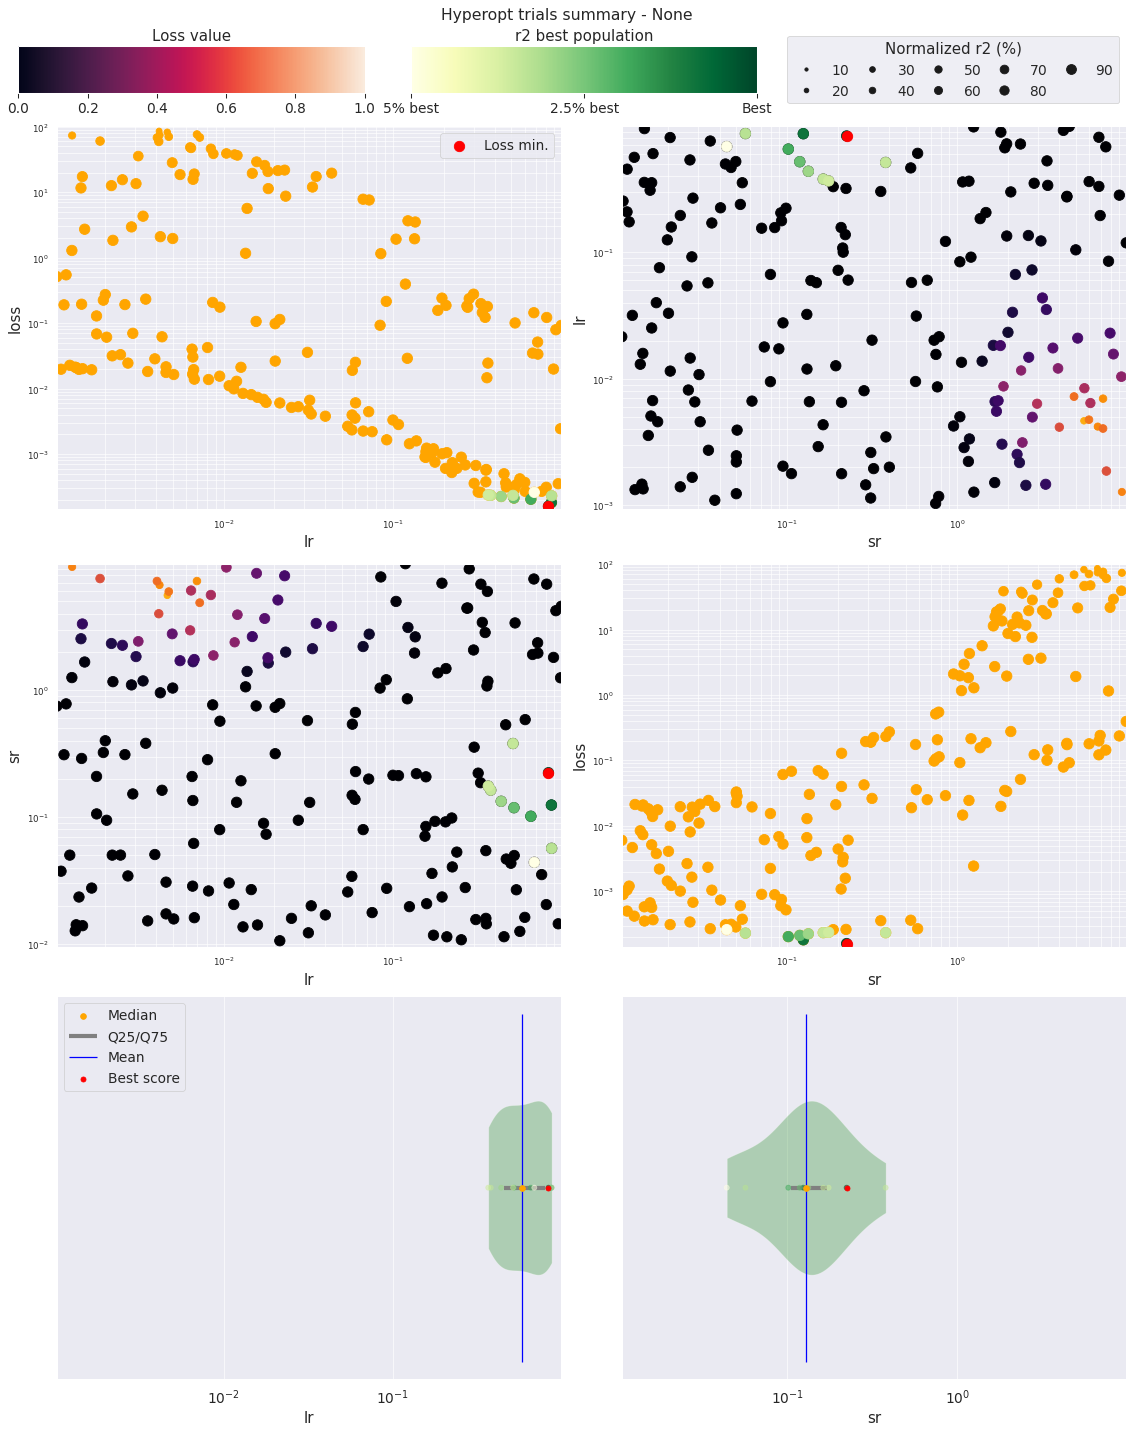

In [20]:
from reservoirpy.hyper import plot_hyperopt_report
fig = plot_hyperopt_report(hyperopt_config["exp"], ("lr", "sr"), metric="r2")

In this plot, each dot represents an instance of the hyper-parameter exploration. The red dot is the lowest loss, and the green dots are the bests values for the chosen metric, here the $R^2$ score.

The diagonal plots show the influence of each parameter on the loss.

The other scatter plots show the interaction of two parameters.

The violin plots below help giving an overview of the parameter distribution of the bests results.